In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palette import *
import statsmodels.api as sm


# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home7/pharos/othr/cgonzale/data/iwsst_mit/1month/'
datadir_out = '/home7/pharos/othr/cgonzale/data/iwsst_mit/working/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/Simul_MITgcm/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
datadir_tides2 = '/home2/pharos/othr/aponte/tides/FES2014/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

palette = '/home3/homedir7/perso/cgonzale/IWAVE/script/palette/medspiration.rgb'
csst = getColorMap( rgbFile = palette )

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
Region = 'AustraliaHW'
if(Region == 'AustraliaHW'):
    fregion = 'nwa_'
elif (Region == 'Mozamb2'):
    fregion = 'mad_'

In [4]:
file='nwa_SST.nc'
dsSST = xr.open_dataset(datadir+file,chunks={'j':100})
file = 'nwa_Eta.nc'
dsSSH = xr.open_dataset(datadir+file,chunks={'j':100})

In [5]:
print(dsSST)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    SST      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


In [6]:
print(dsSSH)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    Eta      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


## Check for vivo/morto periods

In [7]:
day2second = 3600*24
t0 = 1.35e7+(3600*36)+day2second
tf= t0+2*day2second

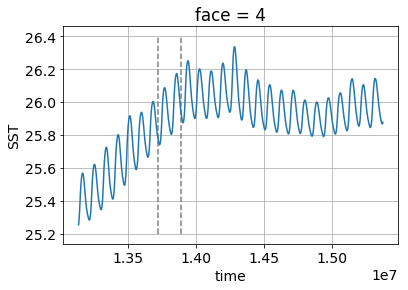

In [8]:
Tmean_xy = dsSST['SST'].mean(dim=['i','j'])
Tmean_xy.plot()
plt.vlines(x=t0, ymin=25.2,ymax=26.4,linestyle='dashed',colors='gray')
plt.vlines(x=tf, ymin=25.2,ymax=26.4,linestyle='dashed',colors='gray')
plt.grid()

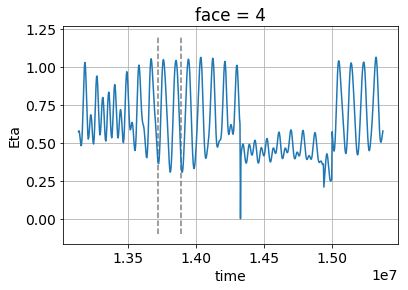

In [9]:
Eta_mean_xy = dsSSH['Eta'].mean(dim=['i','j'])
Eta_mean_xy.plot()
plt.vlines(x=t0, ymin=-0.1,ymax=1.2,linestyle='dashed',colors='gray')
plt.vlines(x=tf, ymin=-0.1,ymax=1.2,linestyle='dashed',colors='gray')
plt.grid()

### Select vivo period (2days) t_0:t_f

In [10]:
#Select region for HW

In [11]:
if (Region == 'AustraliaHW'):
    latmin_z = -22 #-14,-13
    latmax_z = -13#-12, -7
    lonmin_z =  114#52,49
    lonmax_z =  124#55,53
    vmin = 22
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
    it=1
   

sst2d_t = dsSST['SST'].where(dsSST['SST']['XC']>=lonmin_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['XC']<=lonmax_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['YC']<=latmax_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['YC']>=latmin_z, drop=True)

In [12]:
print(sst2d_t)

<xarray.DataArray (time: 625, j: 492, i: 480)>
dask.array<shape=(625, 492, 480), dtype=float32, chunksize=(625, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>


In [13]:
#select in time
sst2d_2days=sst2d_t.sel(time=slice(t0,tf))
print(sst2d_2days)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float32, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


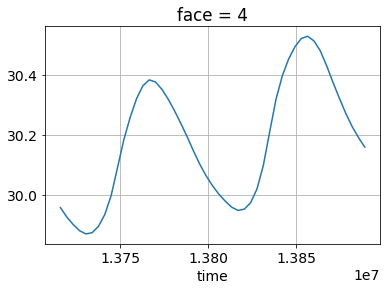

In [14]:
Tmean_xy_2days =sst2d_2days.mean(dim=['i','j'])
Tmean_xy_2days.plot()
plt.grid()

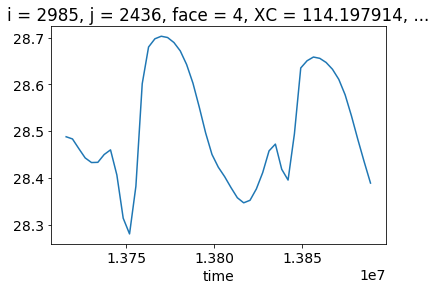

In [15]:
## select one pixel
sst_t=sst2d_2days.sel(i=2985,j=2436)
sst_t.plot()

In [16]:
print(sst_t.XC.values,sst_t.YC.values)

114.197914 -21.823694


In [17]:
t=sst_t.time
print(t)

<xarray.DataArray 'time' (time: 49)>
array([13716000., 13719600., 13723200., 13726800., 13730400., 13734000.,
       13737600., 13741200., 13744800., 13748400., 13752000., 13755600.,
       13759200., 13762800., 13766400., 13770000., 13773600., 13777200.,
       13780800., 13784400., 13788000., 13791600., 13795200., 13798800.,
       13802400., 13806000., 13809600., 13813200., 13816800., 13820400.,
       13824000., 13827600., 13831200., 13834800., 13838400., 13842000.,
       13845600., 13849200., 13852800., 13856400., 13860000., 13863600.,
       13867200., 13870800., 13874400., 13878000., 13881600., 13885200.,
       13888800.])
Coordinates:
    i        int64 2985
    j        int64 2436
    face     int64 4
    XC       float32 dask.array<shape=(), chunksize=()>
    YC       float32 dask.array<shape=(), chunksize=()>
    rA       float32 dask.array<shape=(), chunksize=()>
    Depth    float32 dask.array<shape=(), chunksize=()>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e

In [18]:
dt = t[1]-t[0]
print(dt.values)

3600.0


In [19]:
omega_M2=1.923*cpd# rad/s

In [20]:
1.923*cpd

0.00013984450631604565

In [21]:
sst_t_mean=sst_t.mean()
print(sst_t_mean.values)

28.504318


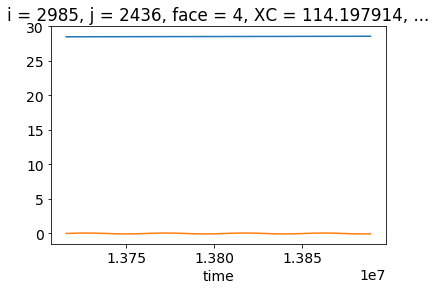

In [22]:
def get_slow_fast (v, omega=omega_M2, omega2=omega_M2/2):
    """ Extract the tidal signal with a harmonic analysis 
    The fit looks like: v = v0 + v1 x t + sum( vi_c cos(omega x t) + vi_s sin(omega x t))
    or:  v = v0 + v1 x t + sum( vi_c cos(omega x t) + vi_s sin(omega x t)) + sum( vi_c cos(omega2 x t) + vi_s sin(omega2 x t))
        Parameters
    ----------
        v:
            signal to decompose
        t:
            time line in seconds
        omega:
            tidal frequency in rad/s (M2 = 1.39844e-4)
        omega2:
            diurnal frequency in rad/s (M2/2 = 0,69922e-4)
    """
    t = v.time
    Nt = t.shape
    if (omega2 is not None):
        Xx = [t*0.+1., t , np.cos(omega*t), np.sin(omega*t), np.cos(omega2*t), np.sin(omega2*t)]
        X = np.vstack((np.ones_like(t),t,np.cos(omega*t),np.sin(omega*t),np.cos(omega2*t),np.sin(omega2*t)))
    else:
        X = np.vstack((np.ones_like(t),t,np.cos(omega*t),np.sin(omega*t)))
        Xx = [t*0.+1., t , np.cos(omega*t), np.sin(omega*t)]
    
    X=X.transpose()
    Mx=np.linalg.inv(X.transpose().dot(X))
    
   
    
    XtY = [(x*v*Nt).mean(dim='time') for x in Xx]

    B = []
    for i in range(len(Xx)):
        B.append(XtY[0]*0.)
        for j in range(len(Xx)):
            B[-1] += Mx[i,j]*XtY[j]
    
    vslow = B[0]*Xx[0] + B[1]*Xx[1]
    vfast = B[2]*Xx[2] + B[3]*Xx[3]
    
    return vslow, vfast

#sst2d_2days
#print(sst_t)
vslow, vfast = get_slow_fast(sst_t)
#Xty_func=get_slow_fast(sst_t)
#print(Xty_func)
#print(vslow)
vslow.plot()
vfast.plot()

# Decompose semidiurnal component

In [23]:
vslow_semi, vfast_semi = get_slow_fast(sst2d_2days)


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


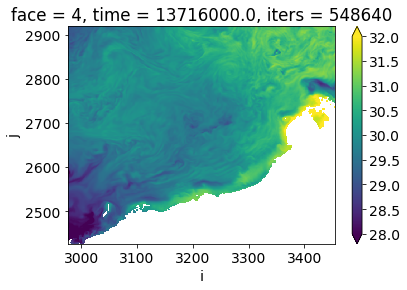

In [24]:
vslow_semi.isel(time=0).plot(vmin=28,vmax=32)

In [25]:
print(vslow_semi.name)

None


In [26]:
vslow_semi.name = 'SST_slow_semi'
vfast_semi.name = 'SST_fast_semi'

In [27]:
print(vslow_semi.name,vfast_semi.name)

SST_slow_semi SST_fast_semi


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


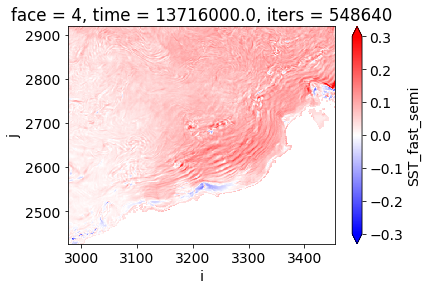

In [28]:
vfast_semi.isel(time=0).plot(vmin=-0.3,vmax=0.3, cmap = 'bwr')

In [29]:
vfast_semi_ij=vfast_semi.sel(i=2985,j=2436)
vslow_semi_ij=vslow_semi.sel(i=2985,j=2436)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


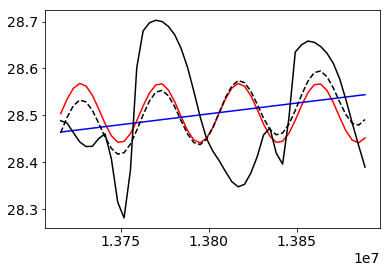

In [30]:
plt.plot(t,vfast_semi_ij+sst_t_mean,c='r')
plt.plot(t,vslow_semi_ij,c='b')
plt.plot(t,sst_t,c='k')
plt.plot(t,vfast_semi_ij+vslow_semi_ij,c='k',linestyle='--')

### Save NetCDF

In [31]:
print(vslow_semi)

<xarray.DataArray 'SST_slow_semi' (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [32]:
file_out = datadir_out+'fast_SST_semidiurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)

##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [33]:

file_out = datadir_out+'slow_SST_semidiurnal.nc'

if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [34]:
def skill(vtrue,v,t=None, Tedge=None):
    """ compute the skill of a reconstruction (v) of the vtrue signal
    """
   
    dif_vtrue_v = vtrue - v
    skill = 1. - dif_vtrue_v.std('time')/vtrue.std('time')
    #CI90 = 1.7*np.sqrt(1-skill)*np.std(vtrue) # gaussian assumption, 90%
    
    return skill

In [35]:
sst_recons_semi= vslow_semi+vfast_semi
skill_semi = skill(sst2d_2days, sst_recons_semi)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


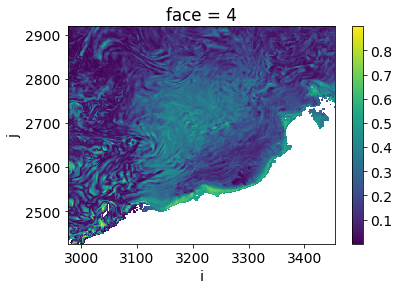

In [36]:
skill_semi.plot()

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


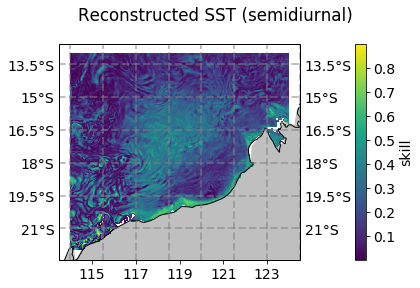

In [37]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_semi.XC,vslow_semi.YC,skill_semi, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (semidiurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill.png'
frame = graphdir+'movies/Semidiurnal_SST/'+figname
fig.savefig(frame, dpi=150)

## Decompose diurnal component

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


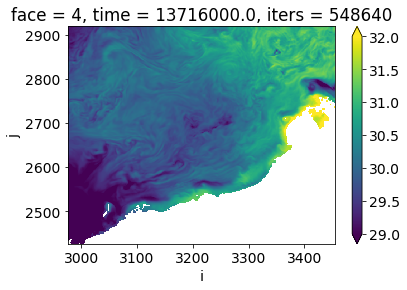

In [38]:

vslow_diurnal, vfast_diurnal = get_slow_fast(sst2d_2days,omega=omega_M2/2)
vslow_diurnal.isel(time=0).plot(vmin=29,vmax=32)

In [39]:
vslow_diurnal.name = 'SST_slow_diurnal'
vfast_diurnal.name = 'SST_fast_diurnal'

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


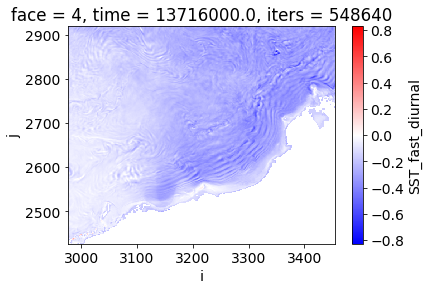

In [40]:
vfast_diurnal.isel(time=0).plot( cmap = 'bwr')

In [41]:
vfast_ij_diurnal=vfast_diurnal.sel(i=2985,j=2436)
vslow_ij_diurnal=vslow_diurnal.sel(i=2985,j=2436)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


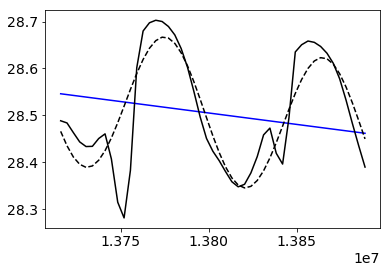

In [42]:
#plt.plot(t,vfast_ij+sst_t_mean,c='r')
plt.plot(t,vslow_ij_diurnal,c='b')
plt.plot(t,sst_t,c='k')
plt.plot(t,vfast_ij_diurnal+vslow_ij_diurnal,c='k',linestyle='--')

In [43]:
sst_t_no_diurnal=sst_t-vfast_ij_diurnal-vslow_ij_diurnal

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


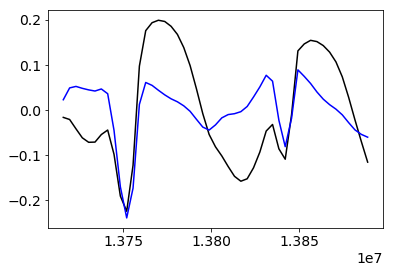

In [44]:
plt.plot(t,sst_t-sst_t_mean,c='k')
plt.plot(t,sst_t_no_diurnal,c='b')

In [45]:
vslow_semi_no_diurnal, vfast_semi_no_diurnal = get_slow_fast(sst_t_no_diurnal,omega=omega_M2)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


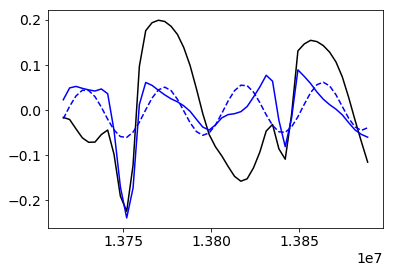

In [46]:
plt.plot(t,sst_t-sst_t_mean,c='k')
plt.plot(t,sst_t_no_diurnal,c='b')
plt.plot(t,vslow_semi_no_diurnal+vfast_semi_no_diurnal,c='b',linestyle='--')

### Save NetCDF

In [47]:
file_out = datadir_out+'fast_SST_diurnal_dum.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [48]:
file_out = datadir_out+'slow_SST_diurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [49]:
sst_recons_diurnal= vslow_diurnal+vfast_diurnal
skill_diurnal = skill(sst2d_2days, sst_recons_diurnal)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


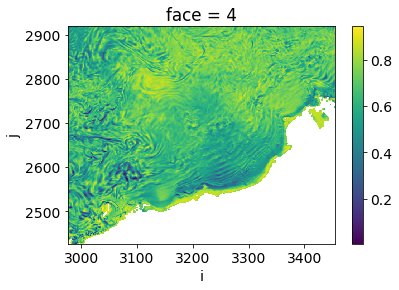

In [50]:
skill_diurnal.plot()


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


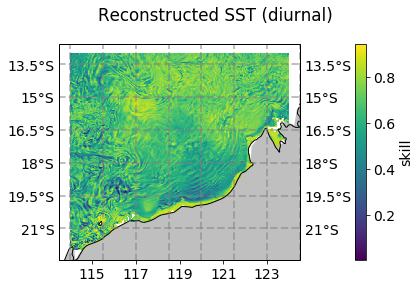

In [51]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_diurnal.XC,vslow_diurnal.YC,skill_diurnal, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (diurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill.png'
frame = graphdir+'movies/Diurnal_SST/'+figname
fig.savefig(frame, dpi=150)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


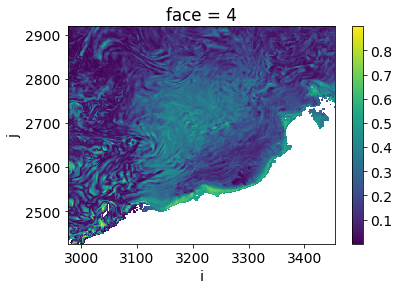

In [52]:
skill_semi.plot()

In [53]:
print('semidiurnal max skill=',np.nanmax(skill_semi.values),'diurnal max sikill:',np.nanmax(skill_diurnal))

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


semidiurnal max skill= 0.8992174652283534 diurnal max sikill: 0.9434343641449281


### Decompose semidiurnal component after removing diurnal cycle

In [54]:
sst_2d_recons_diurnal = vslow_diurnal + vfast_diurnal
sst2d_2days_no_diurnal = sst2d_2days - sst_2d_recons_diurnal

In [55]:
vslow_semi_no_diurnal, vfast_semi_no_diurnal = get_slow_fast(sst2d_2days_no_diurnal,omega=omega_M2)

In [56]:
vrecons_semi_no_diurnal = vslow_semi_no_diurnal + vfast_semi_no_diurnal

In [57]:
skill_semi_no_diurnal = skill(sst2d_2days_no_diurnal, vrecons_semi_no_diurnal)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


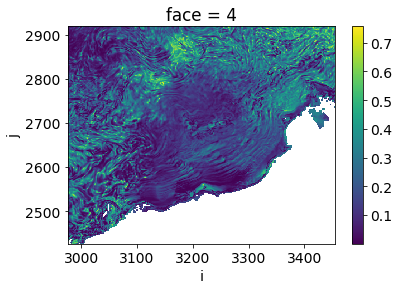

In [58]:
skill_semi_no_diurnal.plot()

In [59]:
print(vslow_semi_no_diurnal)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [60]:
vslow_semi_no_diurnal.name = 'SST_slow_semi_diurnal_corrected'
vfast_semi_no_diurnal.name = 'SST_fast_semi_diurnal_corrected'

In [61]:
file_out = datadir_out+'fast_SST_semi_diurnal_corrected.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_semi_no_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [62]:
file_out = datadir_out+'slow_SST_semi_diurnal_corrected.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_semi_no_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
